In [1]:
import numpy as np
from matplotlib import pyplot as plt

import xgboost as xgb
import ReliefF as rff

from tqdm import tqdm

from sklearn.metrics import auc, accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
class FeatBoost():
    """FeatBoost algorithm for feature selection.
    Inputs: two classificators for feature ranking and estimating. \n
    classificator_1 must support .features_importances_ and .predict_log_proba (check skleran models for example).
    """
    def __init__(self, classificator_1 = None, classificator_2 = None) -> None:
        self.x = None
        self.y = None
        self.trained = False

        self.classificator_1 = classificator_1
        self.classificator_2 = classificator_2

        self.k = 5
        self.m = 3
        self.err = 0.01
        self.test_size = 0.2

        self.selected_features = None
        self.n_features = None

        self.sample_weights = None
        self.alpha_coef = None
        self.accuracy_list = None
        pass

    def fit(self, X, y) -> None:
        """Fit the framework. \n
        Inputs: \n
        X: array-like,
        y: array-like, \n
        This array will fit two chosen classificators.
        """
        self.x = X
        self.y = y
        self.trained = False
        pass

    def set_classificators(self, new_classificator_1 = None, new_classificator_2 = None):
        """ Set new classificator to the framework.
        Inputs:
        new_classififcator_1: Model to calculate features ranking. 
        new_classificator_2: Model to evaluate model with selected top features. 
        """
        if new_classificator_1 != None:
            self.classificator_1 = new_classificator_1
        if new_classificator_2 != None:
            self.classificator_2 = new_classificator_2
        pass

    def set_params(self, k = None, m = None, err = None, test_size = None):
        """ Set additional parameters for feature selecting algorithm. \n
        Inputs:
        k: int, default = 5 
        m: int, default = 3 
        err: float, default = 1e-3
        test_size: float in (0, 1), default = 0.2

        k - parameters for k-fold cross-validation \n
        m - number of chosen features after features ranking with classificator_1 \n
        err - error size to evaluate new feature to continue \n
        test_size: fit sklearn.model_selection.train_test_split for test set size \n
        """
        if k != None:
            self.k = k
        if m != None:
            self.m = m
        if err != None:
            self.err = err
        if test_size != None:
            self.test_size = test_size
        pass

    def get_logs(self):
        """ Get some information in feature selecting algorithm \n
        Return: [sample_weights, alpha_coefficients, accuracy_list]
        """
        return [self.sample_weights, self.alpha_coef, self.accuracy_list]

    def feature_selecting(self, n_features) -> None:
        """ Start the feature selected algorithm. \n
        Before start you need fit framework with .fit(X, y) \n
        Also you can set parameters with .set_params() and classificators with .set_classificators()
        """
        
        x_train, x_test, y_train, y_test = train_test_split(self.x, self.y, test_size=self.test_size)

        n = x_train.shape[0]
        self.selected_features = np.array([], dtype=int)
        self.accuracy_list = []
        self.alpha_coef = [np.ones(n)]
        self.n_features = n_features

        model_1 = self.classificator_1
        model_2 = self.classificator_2

        acc_delta = 0

        for i in tqdm(range(self.n_features)):
            features_ranking = []
            cross_val = []
            pass_fisrt = False

            self.sample_weights = np.ones(n) / n

            model_1.fit(x_train, y_train, self.sample_weights)

            for feature_idx in np.argsort(model_1.feature_importances_)[::-1]:
                if feature_idx not in self.selected_features:
                    features_ranking.append(feature_idx)
                if len(features_ranking) == self.m:
                    break
            
            for feature_idx in features_ranking:
                cross_val.append((cross_val_score(model_2, x_train[:, np.append(self.selected_features, feature_idx)], y_train, cv=self.k).mean(), feature_idx))
            
            top_feature = sorted(cross_val, key=lambda x: x[0])[-1][1]

            if not pass_fisrt:
                model_2.fit(x_train[:, top_feature].reshape(-1, 1), y_train)
                self.accuracy_list.append(accuracy_score(y_test, model_2.predict(x_test[:, top_feature].reshape(-1, 1))))
                pass_fisrt = True
                acc_delta = self.err + 1
                pass
            else:
                model_2.fit(x_train[:, np.append(self.selected_features, top_feature)], y_train)
                self.accuracy_list.append(accuracy_score(y_test, model_2.predict(x_test[:, np.append(self.selected_features, top_feature)])))
                acc_delta = np.abs(self.accuracy_list[-1] - self.accuracy_list[-2])
            
            if acc_delta > self.err:
                self.selected_features = np.append(self.selected_features, top_feature)

                model_1.fit(x_train[:, self.selected_features], y_train)

                self.alpha_coef.append(model_1.predict_log_proba(x_train[:, self.selected_features]))
                self.alpha_coef[-1][self.alpha_coef[-1] == -np.inf] = -1
                self.alpha_coef[-1] = -self.alpha_coef[-1].sum(axis=1) / self.alpha_coef[-2]

                self.sample_weights *= self.alpha_coef[-1]
                self.sample_weights /= self.sample_weights.sum()
            else:
                self.sample_weights = np.ones(n) / n
                break
        self.trained = True
        pass

    def get_subset(self, n_features = None):
        """ Get subset of selected features.
        Return: np.array
        """
        if self.trained == True:
            return self.selected_features
        else:
            self.feature_selecting(n_features=n_features)
            return self.selected_features

In [179]:
import pickle

file_ = 'data/featboost_rfc_knn_5-40_covtypes.txt'

with open(file_, 'wb') as fp:
    pickle.dump(lst_feat_rfc, fp)


In [130]:
file__ = 'data/featboost_gbc_knn_1-20_breast.txt'

with open(file__, 'rb') as fp:
    lst_feat_gbc = pickle.load(fp)

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

data = load_breast_cancer()
X = data.data
y = data.target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [133]:
model1 = GradientBoostingClassifier()
model2 = KNeighborsClassifier()

lst_feat_gbc = []

for i in range(1, 21):
    model_ = FeatBoost(model1, model2)
    model_.fit(X, y)
    model_.set_params(m=50, err=0.00001)
    model_.feature_selecting(i)
    aa = model_.get_subset()
    lst_feat_gbc.append(aa)

100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


In [134]:
lst_xgb = []

for i in range(1, 21):
    xgb_ = xgb.XGBClassifier()
    xgb_.fit(x_train, y_train)

    lst_xgb.append(np.argsort(xgb_.feature_importances_)[::-1][:i])

#selected = np.argsort(xgb_.feature_importances_)[::-1][:10]

In [135]:


lst_rfc = []

for i in range(1, 21):
    rfc = RandomForestClassifier()
    rfc.fit(x_train, y_train)
    
    lst_rfc.append(np.argsort(rfc.feature_importances_)[::-1][:i])

#selected_features = np.argsort(rfc.feature_importances_)[::-1][:10]

In [4]:
from sklearn.feature_selection import SelectKBest, chi2

skb = SelectKBest(chi2, k=10)
skb.fit(x_train, y_train)

preselected = []

for i in skb.get_feature_names_out():
    s = ''.join(x for x in i if x.isdigit())
    preselected.append(int(s))

In [136]:
lst_skb = []

for i in range(1, 21):
    skb = SelectKBest(chi2, k=i)
    skb.fit(x_train, y_train)

    preselected = []

    for i in skb.get_feature_names_out():
        s = ''.join(x for x in i if x.isdigit())
        preselected.append(int(s))
    
    lst_skb.append(preselected)

In [29]:
mm = aa
nn = len(mm)
summa = 0

for i in range(nn):
    for j in range(i + 1, nn):
        summa += 1 / (nn * (nn - 1)) * np.abs(pearsonr(X[:, mm[i]], X[:, mm[j]])[0])

print(f"Featboost {summa}")

mm = selected_features
nn = len(mm)
summa = 0

for i in range(nn):
    for j in range(i + 1, nn):
        summa += 1 / (nn * (nn - 1)) * np.abs(pearsonr(X[:, mm[i]], X[:, mm[j]])[0])

print(f"Randomforest {summa}")

mm = selected
nn = len(mm)
summa = 0

for i in range(nn):
    for j in range(i + 1, nn):
        summa += 1 / (nn * (nn - 1)) * np.abs(pearsonr(X[:, mm[i]], X[:, mm[j]])[0])

print(f"XGBoost {summa}")

mm = preselected
nn = len(mm)
summa = 0

for i in range(nn):
    for j in range(i + 1, nn):
        summa += 1 / (nn * (nn - 1)) * np.abs(pearsonr(X[:, mm[i]], X[:, mm[j]])[0])

print(f"SelectKBest {summa}")

Featboost 0.1455247618950717
Randomforest 0.2134382097961907
XGBoost 0.1463856132420803
SelectKBest 0.30386736859696784


In [118]:
acc_feat_gbc = []
acc_xgb = []
acc_rfc = []
acc_skb = []

for i in range(10):
    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lstt[i]], y_train)
    acc_feat_gbc.append(accuracy_score(y_test, val_model.predict(x_test[:, lstt[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_xgb[i]], y_train)
    acc_xgb.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_xgb[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_rfc[i]], y_train)
    acc_rfc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_rfc[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_skb[i]], y_train)
    acc_skb.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_skb[i]])))

In [121]:
acc_feat_rfc = []

file__ = 'data/featboost_rfc_knn_5-50.txt'

with open(file__, 'rb') as fp:
    lst_feat_rfc = pickle.load(fp)

for i in range(10):
    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_feat_rfc[i]], y_train)
    acc_feat_rfc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_feat_rfc[i]])))

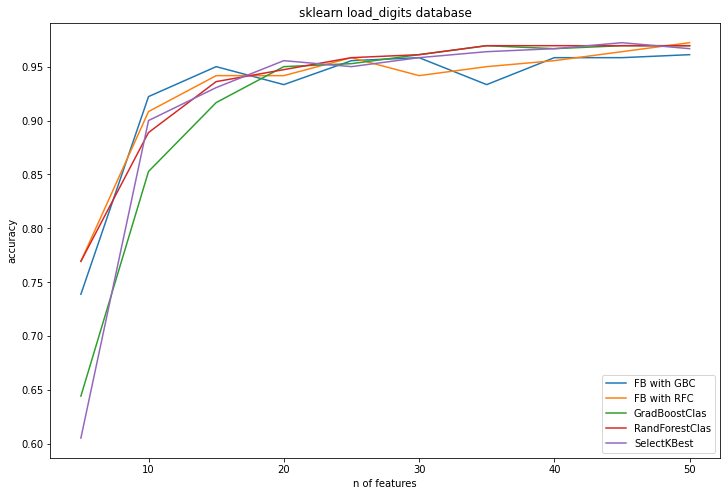

In [127]:
x_line = [i for i in range(5, 51, 5)]

plt.figure(figsize=(12, 8))
plt.plot(x_line, acc_feat_gbc, label='FB with GBC')
plt.plot(x_line, acc_feat_rfc, label='FB with RFC')
plt.plot(x_line, acc_xgb, label='GradBoostClas')
plt.plot(x_line, acc_rfc, label='RandForestClas')
plt.plot(x_line, acc_skb, label='SelectKBest')
plt.title('sklearn load_digits database')
plt.xlabel('n of features')
plt.ylabel('accuracy')
plt.legend()


In [149]:
acc_feat_gbc = []
acc_feat_rfc = []
acc_xgb = []
acc_rfc = []
acc_skb = []

for i in range(20):
    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_feat_gbc[i]], y_train)
    acc_feat_gbc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_feat_gbc[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_feat_rfc[i]], y_train)
    acc_feat_rfc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_feat_rfc[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_xgb[i]], y_train)
    acc_xgb.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_xgb[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_rfc[i]], y_train)
    acc_rfc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_rfc[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_skb[i]], y_train)
    acc_skb.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_skb[i]])))

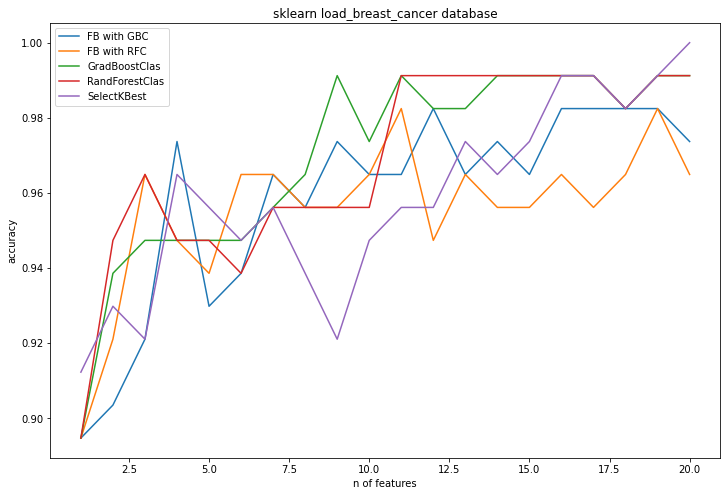

In [151]:
x_line = [i for i in range(1, 21)]

plt.figure(figsize=(12, 8))
plt.plot(x_line, acc_feat_gbc, label='FB with GBC')
plt.plot(x_line, acc_feat_rfc, label='FB with RFC')
plt.plot(x_line, acc_xgb, label='GradBoostClas')
plt.plot(x_line, acc_rfc, label='RandForestClas')
plt.plot(x_line, acc_skb, label='SelectKBest')
plt.title('sklearn load_breast_cancer database')
plt.xlabel('n of features')
plt.ylabel('accuracy')
plt.legend()

In [153]:
from sklearn.datasets import fetch_covtype

data = fetch_covtype()

x = data.data[:5000]
y = data.target[:5000]

In [169]:
lst_feat_gbc = []
lst_feat_rfc = []
lst_skb = []
lst_rfc = []
lst_xgb = []

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

for i in range(5, 41, 5):
    fb_gbc = FeatBoost(GradientBoostingClassifier(), KNeighborsClassifier())
    fb_gbc.set_params(m = 10, err = 1e-4)
    fb_gbc.fit(x_train, y_train)
    lst_feat_gbc.append(fb_gbc.get_subset(i))

    fb_rfc = FeatBoost(RandomForestClassifier(), KNeighborsClassifier())
    fb_rfc.set_params(m = 10, err = 1e-4)
    fb_rfc.fit(x_train, y_train)
    lst_feat_rfc.append(fb_rfc.get_subset(i))

    xgb_ = xgb.XGBClassifier()
    xgb_.fit(x_train, y_train)
    lst_xgb.append(np.argsort(xgb_.feature_importances_)[::-1][:i])

    rfc = RandomForestClassifier()
    rfc.fit(x_train, y_train)
    lst_rfc.append(np.argsort(rfc.feature_importances_)[::-1][:i])


  0%|          | 0/5 [00:00<?, ?it/s]c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\site-packages\sklearn\ensemble\_forest.py:922: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
 20%|██        | 1/5 [00:02<00:08,  2.18s/it]c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\site-packages\sklearn\ensemble\_forest.py:922: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
 40%|████      | 2/5 [00:04<00:06,  2.17s/it]c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\site-packages\sklearn\ensemble\_forest.py:922: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\site-packages\sklearn\ensemble\_forest.py:922: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]c:\Program Files (x86)\

In [173]:
acc_feat_gbc = []
acc_feat_rfc = []
acc_xgb = []
acc_rfc = []

for i in range(8):
    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_feat_gbc[i]], y_train)
    acc_feat_gbc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_feat_gbc[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_feat_rfc[i]], y_train)
    acc_feat_rfc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_feat_rfc[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_xgb[i]], y_train)
    acc_xgb.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_xgb[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_rfc[i]], y_train)
    acc_rfc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_rfc[i]])))

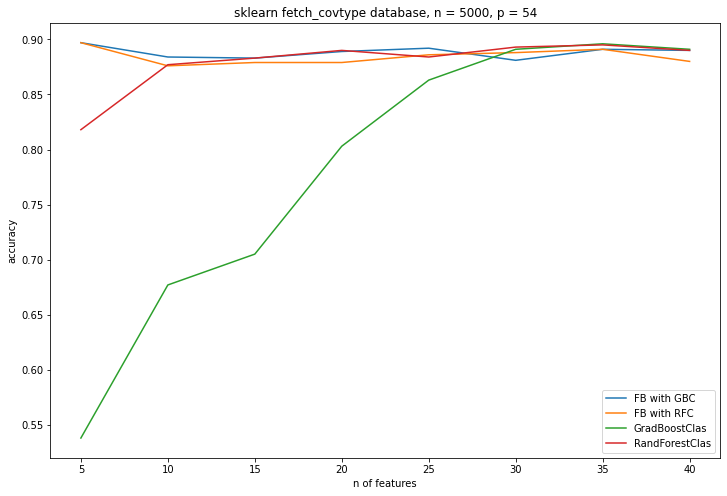

In [177]:
x_line = [i for i in range(5, 41, 5)]

plt.figure(figsize=(12, 8))
plt.plot(x_line, acc_feat_gbc, label='FB with GBC')
plt.plot(x_line, acc_feat_rfc, label='FB with RFC')
plt.plot(x_line, acc_xgb, label='GradBoostClas')
plt.plot(x_line, acc_rfc, label='RandForestClas')
plt.title('sklearn fetch_covtype database, n = 5000, p = 54')
plt.xlabel('n of features')
plt.ylabel('accuracy')
plt.legend()

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd

In [18]:
data_table = pd.read_csv('datasets/train.csv')
x = data_table.drop(columns=['Survived', 'PassengerId'])
y = data_table['Survived']

In [19]:
x['Age'][x['Age'].isnull()] = x['Age'].dropna().mean()
x['Cabin'][x['Cabin'].isnull()] = 'Unknown'

le = LabelEncoder()

col = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
for i in col:
    x[i] = le.fit_transform(x[i])

x = x.dropna()
x = x.to_numpy()
y = y.to_numpy()

In [23]:
lst_feat_gbc = []
lst_feat_rfc = []
lst_skb = []
lst_rfc = []
lst_xgb = []

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

for i in range(1, 11):
    fb_gbc = FeatBoost(GradientBoostingClassifier(), KNeighborsClassifier())
    fb_gbc.set_params(m = 10, err = 1e-4)
    fb_gbc.fit(x_train, y_train)
    lst_feat_gbc.append(fb_gbc.get_subset(i))

    fb_rfc = FeatBoost(RandomForestClassifier(), KNeighborsClassifier())
    fb_rfc.set_params(m = 10, err = 1e-4)
    fb_rfc.fit(x_train, y_train)
    lst_feat_rfc.append(fb_rfc.get_subset(i))

    xgb_ = xgb.XGBClassifier()
    xgb_.fit(x_train, y_train)
    lst_xgb.append(np.argsort(xgb_.feature_importances_)[::-1][:i])

    rfc = RandomForestClassifier()
    rfc.fit(x_train, y_train)
    lst_rfc.append(np.argsort(rfc.feature_importances_)[::-1][:i])

    skb = SelectKBest(chi2, k=i)
    skb.fit(x_train, y_train)

    preselected = []

    for i in skb.get_feature_names_out():
        s = ''.join(x for x in i if x.isdigit())
        preselected.append(int(s))
    
    lst_skb.append(preselected)

100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


In [21]:
acc_feat_gbc = []
acc_feat_rfc = []
acc_xgb = []
acc_rfc = []
acc_skb = []

for i in range(10):
    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_feat_gbc[i]], y_train)
    acc_feat_gbc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_feat_gbc[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_feat_rfc[i]], y_train)
    acc_feat_rfc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_feat_rfc[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_xgb[i]], y_train)
    acc_xgb.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_xgb[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_rfc[i]], y_train)
    acc_rfc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_rfc[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_skb[i]], y_train)
    acc_skb.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_skb[i]])))

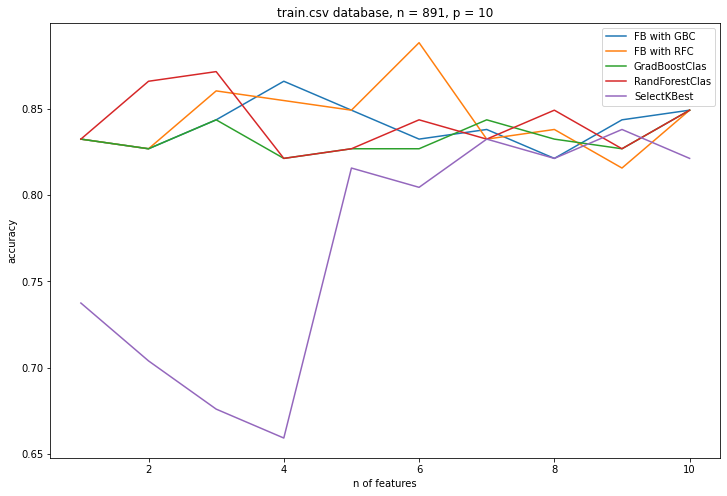

In [22]:
x_line = [i for i in range(1, 11)]

plt.figure(figsize=(12, 8))
plt.plot(x_line, acc_feat_gbc, label='FB with GBC')
plt.plot(x_line, acc_feat_rfc, label='FB with RFC')
plt.plot(x_line, acc_xgb, label='GradBoostClas')
plt.plot(x_line, acc_rfc, label='RandForestClas')
plt.plot(x_line, acc_skb, label='SelectKBest')
plt.title('train.csv database, n = 891, p = 10')
plt.xlabel('n of features')
plt.ylabel('accuracy')
plt.legend()

In [34]:
data_table = pd.read_csv('datasets/ionosphere_csv.csv')
x = data_table.drop(columns='class')
y = data_table['class']

le = LabelEncoder()

y = le.fit_transform(y)

x = x.to_numpy()

In [38]:
lst_feat_gbc = []
lst_feat_rfc = []
lst_skb = []
lst_rfc = []
lst_xgb = []

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

for i in range(1, 25):
    fb_gbc = FeatBoost(GradientBoostingClassifier(), KNeighborsClassifier())
    fb_gbc.set_params(m = 10, err = 1e-4)
    fb_gbc.fit(x_train, y_train)
    lst_feat_gbc.append(fb_gbc.get_subset(i))

    fb_rfc = FeatBoost(RandomForestClassifier(), KNeighborsClassifier())
    fb_rfc.set_params(m = 10, err = 1e-4)
    fb_rfc.fit(x_train, y_train)
    lst_feat_rfc.append(fb_rfc.get_subset(i))

    xgb_ = xgb.XGBClassifier()
    xgb_.fit(x_train, y_train)
    lst_xgb.append(np.argsort(xgb_.feature_importances_)[::-1][:i])

    rfc = RandomForestClassifier()
    rfc.fit(x_train, y_train)
    lst_rfc.append(np.argsort(rfc.feature_importances_)[::-1][:i])

100%|██████████| 24/24 [00:12<00:00,  1.87it/s]


In [40]:
acc_feat_gbc = []
acc_feat_rfc = []
acc_xgb = []
acc_rfc = []

for i in range(24):
    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_feat_gbc[i]], y_train)
    acc_feat_gbc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_feat_gbc[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_feat_rfc[i]], y_train)
    acc_feat_rfc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_feat_rfc[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_xgb[i]], y_train)
    acc_xgb.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_xgb[i]])))

    val_model = xgb.XGBClassifier()
    val_model.fit(x_train[:, lst_rfc[i]], y_train)
    acc_rfc.append(accuracy_score(y_test, val_model.predict(x_test[:, lst_rfc[i]])))

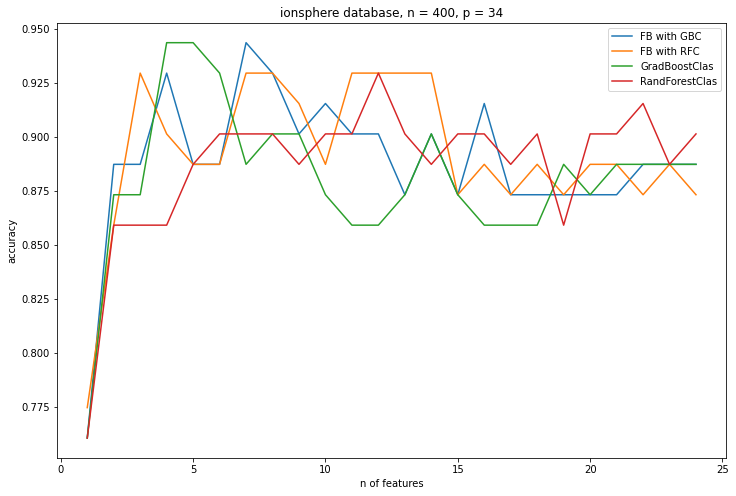

In [42]:
x_line = [i for i in range(1, 25)]

plt.figure(figsize=(12, 8))
plt.plot(x_line, acc_feat_gbc, label='FB with GBC')
plt.plot(x_line, acc_feat_rfc, label='FB with RFC')
plt.plot(x_line, acc_xgb, label='GradBoostClas')
plt.plot(x_line, acc_rfc, label='RandForestClas')
plt.title('ionsphere database, n = 400, p = 34')
plt.xlabel('n of features')
plt.ylabel('accuracy')
plt.legend()